In [1]:
import __init__
from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures,\
                            get_guided_encoder_output,\
                            ESM2_IF_repr
                            
import pandas as pd
import numpy as np
    
path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
complete_meltome_db = '../datasets/FLIP/splits/meltome/full_dataset_sequences.fasta'

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
train, val, test = train_test_validation_splits(splits_meltome)
train = seek_UniprotID_association_Meltome_prots(train, full_meltome_db)
test = seek_UniprotID_association_Meltome_prots(test, full_meltome_db)
val = seek_UniprotID_association_Meltome_prots(val, full_meltome_db)
#print(train)
print("Done")



#ff=full_meltome_db[full_meltome_db['sequence'].isin(train['sequence'])]

Done


In [2]:
from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.ESM2_IF1_embeddings import ESM2_IF1_embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer

structuredir = '../datasets/Structures/'
meltome_struct_dir_labels = '../datasets/'


import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')



Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t')
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t')
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t')


train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')



In [3]:

import torch, os, gc
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import warnings
warnings.filterwarnings('ignore')


"""import esm
model, alphabet = esm.pretrained.load_model_and_alphabet_local("../models/esm_if1_gvp4_t16_142M_UR50.pt")#esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()"""

IF1 = ESM2_IF1_embeddings()


pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2_with_StructAssociation.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2_with_StructAssociation.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2_with_StructAssociation.pth'

path_IFtrain= dir_pre_generated_embeddings+'train_set_IFembeddings_ESM2_StructAssociation.pth'
path_IFtest= dir_pre_generated_embeddings+'test_set_IFembeddings_ESM2_StructAssociation.pth'
path_IFval= dir_pre_generated_embeddings+'val_set_IFembeddings_ESM2_StructAssociation.pth'




def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings


#def IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval):
def IFBuilder_sets(IF, train, test, val, path_IFtrain, path_IFtest, path_IFval):

    if os.path.isfile(path_IFtrain)==False and os.path.isfile(path_IFtest)==False and os.path.isfile(path_IFval)==False:

        #IF_embeddings_train = ESM2_IF_repr(train, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_train')
        IF_embeddings_train = IF.ESM2_IF_repr(train, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_train')
        torch.save(IF_embeddings_train, path_IFtrain)

        #IF_embeddings_test = ESM2_IF_repr(test, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_test')
        IF_embeddings_test = IF.ESM2_IF_repr(test, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_test')
        torch.save(IF_embeddings_test, path_IFtest)

        #IF_embeddings_val = ESM2_IF_repr(val, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_val')
        IF_embeddings_val = IF.ESM2_IF_repr(val, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_val')
        torch.save(IF_embeddings_val, path_IFval)
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_IFtrain)
        test_embeddings = torch.load(path_IFtest)
        val_embeddings = torch.load(path_IFval)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings



In [4]:
train_IF_embedding, test_IF_embedding, val_IF_embedding = IFBuilder_sets(IF1, train, test, val, path_IFtrain, path_IFtest, path_IFval)
train_embeddings, test_embeddings, val_embeddings = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)

train_loaderESM2 = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderESM2 = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderESM2 = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

train_loaderIF = tensor2dataloader(train_IF_embedding, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderIF = tensor2dataloader(test_IF_embedding, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderIF = tensor2dataloader(val_IF_embedding, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

train_loaderMixed = tensor2dataloader(torch.concat([train_embeddings.to(device), train_IF_embedding.to(device)],dim=1), torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderMixed = tensor2dataloader(torch.concat([test_embeddings.to(device), test_IF_embedding.to(device)],dim=1), torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderMixed = tensor2dataloader(torch.concat([val_embeddings.to(device), val_IF_embedding.to(device)],dim=1), torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

Loading Premade Embeddings...
Loaded
Creating Embeddings...
2174 sequences were too long and have been truncated to 1000 AA


  0%|          | 0/1376 [00:00<?, ?it/s]

263 sequences were too long and have been truncated to 1000 AA


  0%|          | 0/193 [00:00<?, ?it/s]

In [6]:
def generating_results_approaches(FFNNreg, Trner, train_loader, val_loader, test_loader,loss, opt, epochs, device):
    FFNNreg, val_loss = Trner.train_LLMRegresor(train_loader, val_loader, FFNNreg, device, loss, opt, epochs)

    test_set, test_labels = test_loader.dataset.tensors
    loss_test, outcome = Trner.test_model(FFNNreg, test_set, test_labels, loss, device)

    from src.utilities import plot_results

    plot_results( outcome, test_labels)

### For RAW ESM2

epoch: 1 loss: 772.099 val loss: 1148.584
epoch: 2 loss: 365.518 val loss: 523.750
epoch: 3 loss: 11.393 val loss: 239.035
epoch: 4 loss: 151.188 val loss: 140.872
epoch: 5 loss: 1.844 val loss: 117.798
epoch: 6 loss: 5.216 val loss: 114.231
epoch: 7 loss: 10.382 val loss: 113.791
epoch: 8 loss: 2.408 val loss: 113.644
epoch: 9 loss: 6.878 val loss: 113.857
epoch: 10 loss: 67.186 val loss: 113.725
epoch: 11 loss: 152.389 val loss: 113.297
epoch: 12 loss: 16.034 val loss: 95.803
epoch: 13 loss: 18.167 val loss: 72.281
epoch: 14 loss: 0.152 val loss: 58.923
epoch: 15 loss: 0.111 val loss: 50.718
epoch: 16 loss: 8.044 val loss: 46.319
epoch: 17 loss: 1.146 val loss: 43.885
epoch: 18 loss: 53.047 val loss: 42.594
epoch: 19 loss: 212.707 val loss: 41.696
epoch: 20 loss: 3.509 val loss: 41.399
epoch: 21 loss: 0.148 val loss: 40.726
epoch: 22 loss: 6.829 val loss: 40.451
epoch: 23 loss: 0.726 val loss: 40.357
epoch: 24 loss: 0.001 val loss: 40.119
epoch: 25 loss: 5.347 val loss: 39.966
epoch:

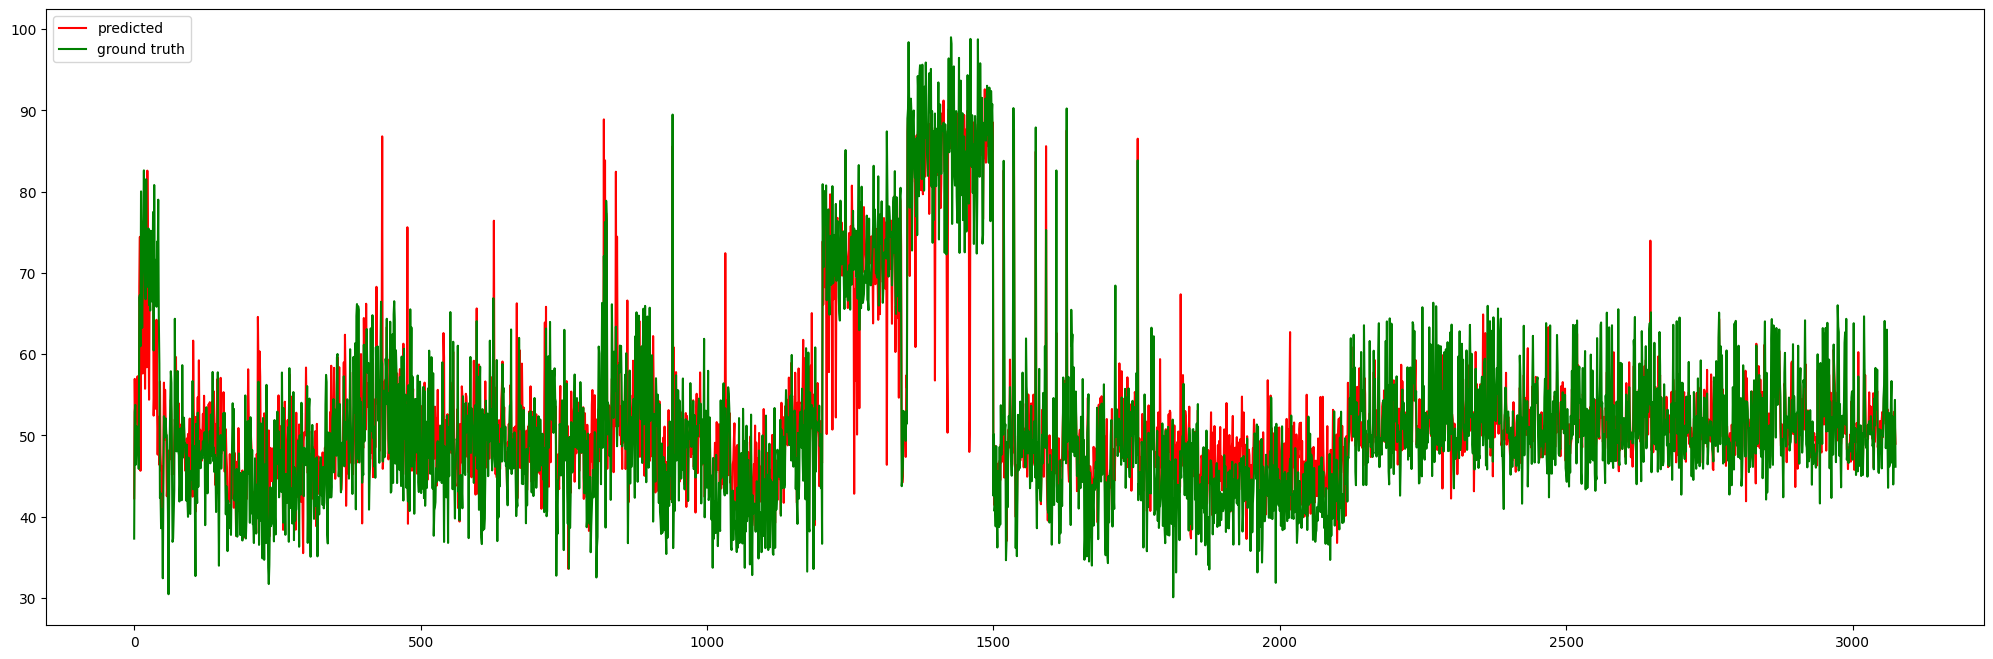

In [7]:
Trainer1 = Trainer()
FFNN_ESM2 = regressionHead(train_embeddings.shape[1::])
optESM2 = torch.optim.Adam(FFNN_ESM2.parameters(), lr=1e-4)
lossESM2= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_ESM2, Trainer1, train_loaderESM2, val_loaderESM2, test_loaderESM2,lossESM2, optESM2, epochs, device)

### For Inverse Folding ESM2 Contribution

epoch: 1 loss: 1010.604 val loss: 1156.050
epoch: 2 loss: 355.904 val loss: 530.566
epoch: 3 loss: 38.891 val loss: 245.789
epoch: 4 loss: 68.963 val loss: 142.991
epoch: 5 loss: 2.160 val loss: 118.343
epoch: 6 loss: 8.708 val loss: 114.490
epoch: 7 loss: 155.957 val loss: 113.581
epoch: 8 loss: 14.468 val loss: 113.536
epoch: 9 loss: 30.077 val loss: 114.122
epoch: 10 loss: 10.897 val loss: 114.163
epoch: 11 loss: 1628.434 val loss: 113.594
epoch: 12 loss: 494.312 val loss: 113.988
epoch: 13 loss: 22.381 val loss: 113.790
epoch: 14 loss: 5.340 val loss: 114.015
epoch: 15 loss: 116.538 val loss: 113.640
epoch: 16 loss: 22.584 val loss: 113.617
epoch: 17 loss: 20.020 val loss: 113.523
epoch: 18 loss: 348.168 val loss: 108.197
epoch: 19 loss: 2.476 val loss: 101.515
epoch: 20 loss: 31.513 val loss: 97.294
epoch: 21 loss: 0.014 val loss: 93.717
epoch: 22 loss: 153.387 val loss: 90.768
epoch: 23 loss: 99.529 val loss: 88.475
epoch: 24 loss: 117.297 val loss: 86.738
epoch: 25 loss: 7.552 v

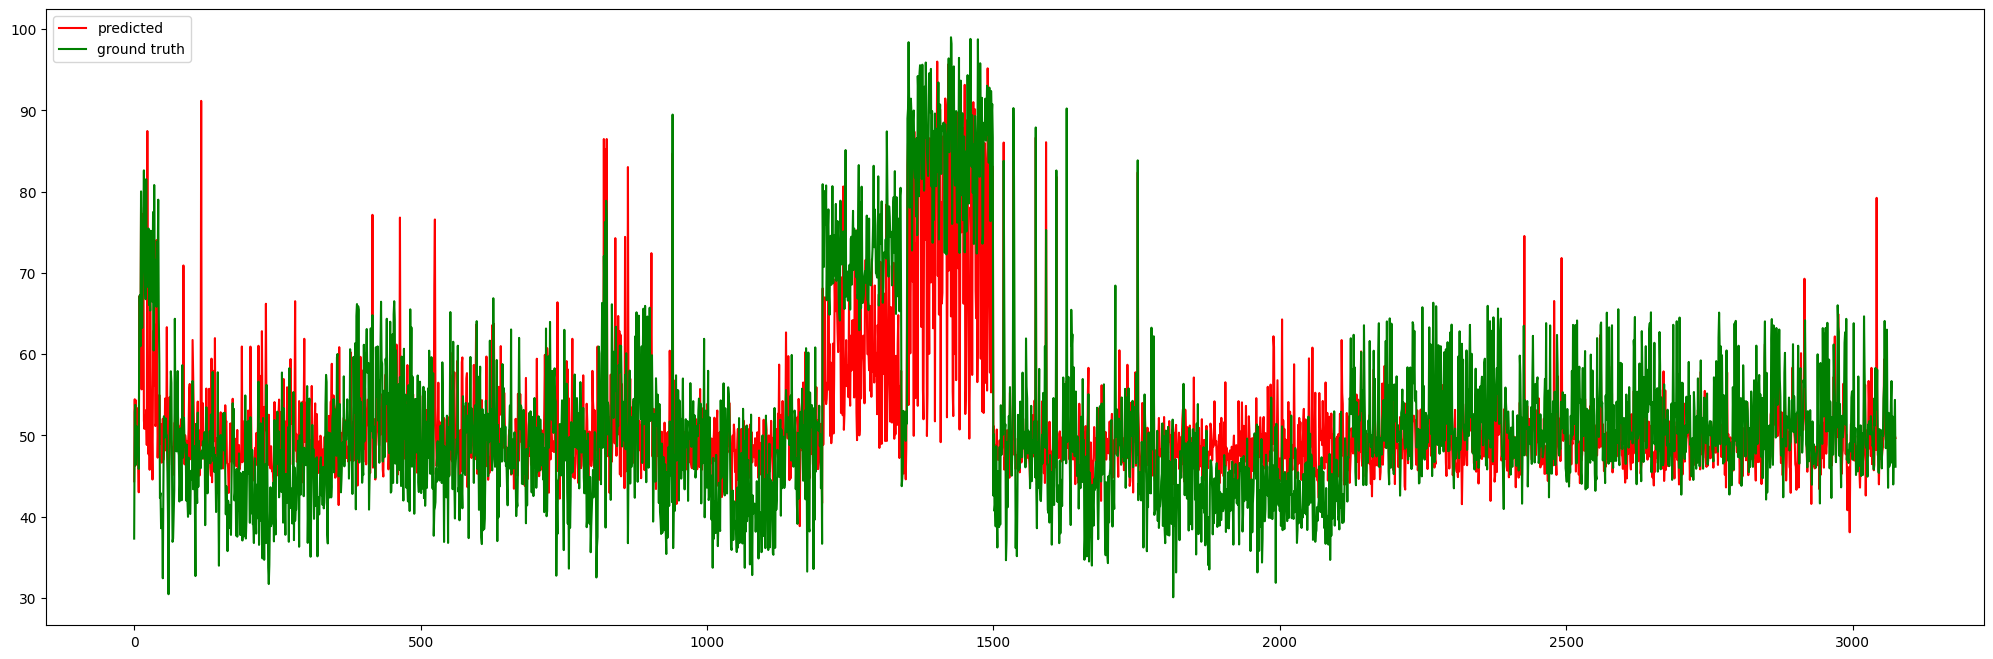

In [8]:
Trainer2 = Trainer()
FFNN_IF = regressionHead(train_IF_embedding.shape[1::] )
optIF = torch.optim.Adam(FFNN_IF.parameters(), lr=1e-4)
lossIF= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_IF, Trainer2, train_loaderIF, val_loaderIF, test_loaderIF,lossIF, optIF, epochs, device)

### Combining Raw ESM2 and Inverse Folding Embeddings

epoch: 1 loss: 5358.125 val loss: 1264.345
epoch: 2 loss: 1036.341 val loss: 633.684
epoch: 3 loss: 404.124 val loss: 308.307
epoch: 4 loss: 155.389 val loss: 169.119
epoch: 5 loss: 4.475 val loss: 125.447
epoch: 6 loss: 466.669 val loss: 115.346
epoch: 7 loss: 1566.633 val loss: 113.829
epoch: 8 loss: 68.810 val loss: 113.818
epoch: 9 loss: 1.976 val loss: 113.948
epoch: 10 loss: 4.036 val loss: 113.586
epoch: 11 loss: 4.704 val loss: 113.733
epoch: 12 loss: 210.418 val loss: 113.548
epoch: 13 loss: 35.255 val loss: 113.817
epoch: 14 loss: 4.762 val loss: 113.658
epoch: 15 loss: 126.715 val loss: 111.367
epoch: 16 loss: 153.083 val loss: 73.812
epoch: 17 loss: 0.181 val loss: 58.327
epoch: 18 loss: 3.734 val loss: 49.781
epoch: 19 loss: 57.566 val loss: 45.130
epoch: 20 loss: 44.577 val loss: 43.248
epoch: 21 loss: 9.270 val loss: 41.564
epoch: 22 loss: 68.940 val loss: 40.507
epoch: 23 loss: 9.967 val loss: 40.043
epoch: 24 loss: 4.039 val loss: 39.830
epoch: 25 loss: 2.456 val loss:

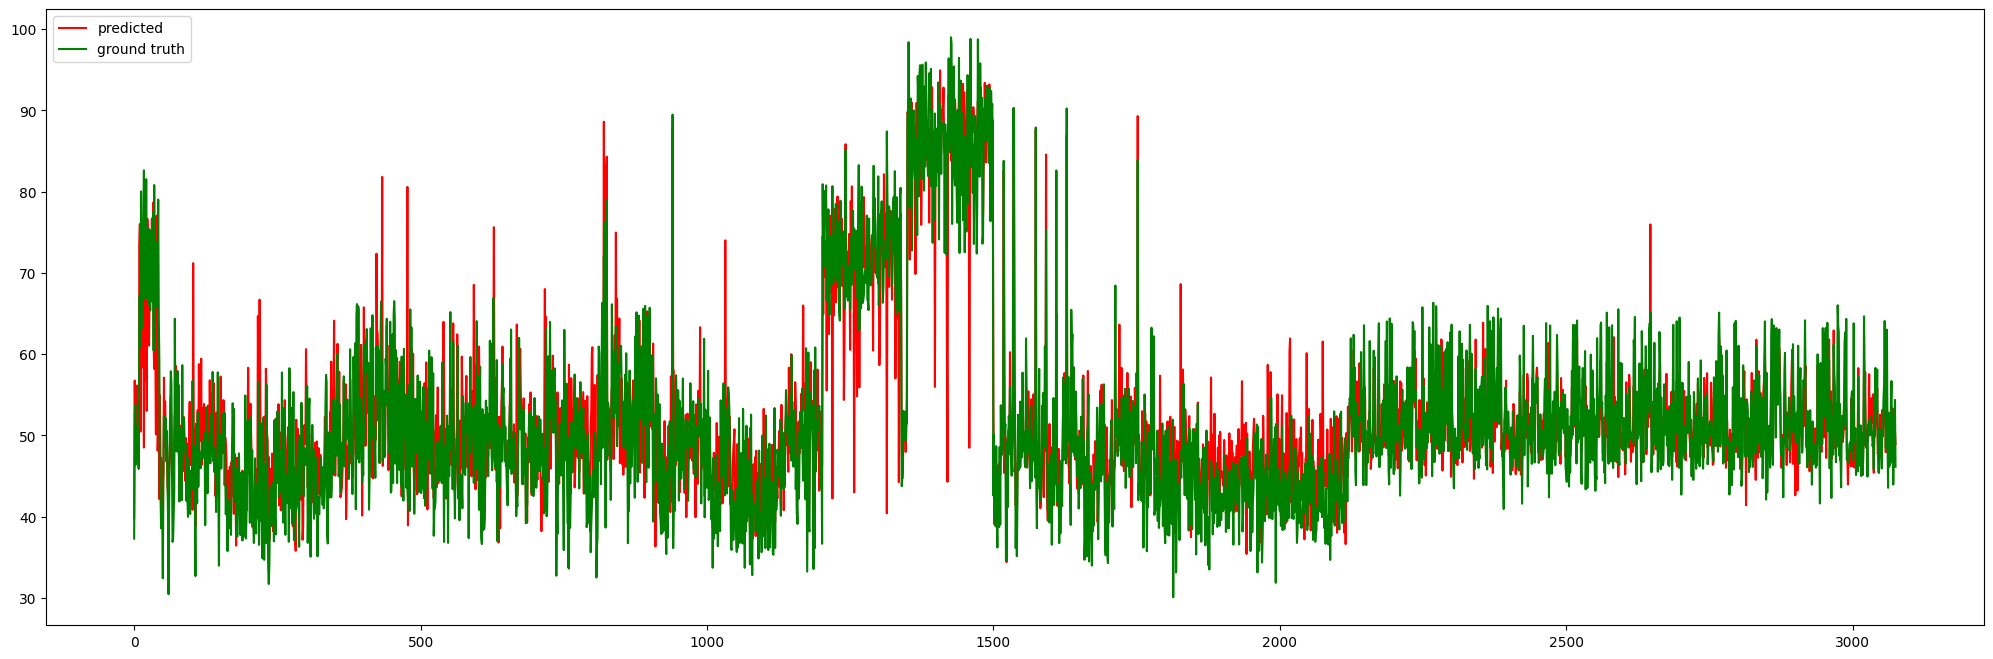

In [14]:
Trainer3 = Trainer()
FFNN_Mixed = regressionHead(train_IF_embedding.size(1) + train_embeddings.size(1))
optMixed = torch.optim.Adam(FFNN_Mixed.parameters(), lr=1e-4)
lossMixed= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_Mixed, Trainer3, train_loaderMixed, val_loaderMixed, test_loaderMixed,lossMixed, optMixed, epochs, device)